<a href="https://colab.research.google.com/github/Fayli775/INFOSYS722-Iteration4/blob/main/02_DU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import skewness, kurtosis

from google.colab import drive
drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("Iteration4-DataUnderstanding") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

file_path = "/content/drive/MyDrive/722/TMS_Telemetry_Sites.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
print("Record count:", df.count())
print("Column count:", len(df.columns))
print("Columns list:", df.columns)

for field in df.schema.fields:
    print(f"{field.name}: {field.dataType}")

df.show(10, truncate=True)

print("Any null columns:", any([df.filter(F.col(c).isNull()).count() == df.count() for c in df.columns]))
print("Any completely empty records:", df.filter(F.col(df.columns[0]).isNull()).count())


Record count: 6660911
Column count: 10
Columns list: ['OBJECTID', 'Start Date', 'Site Alias', 'Region Name', 'Site Reference', 'Class Weight', 'Site Description', 'Lane Number', 'Flow Direction', 'Traffic Count']
OBJECTID: IntegerType()
Start Date: StringType()
Site Alias: IntegerType()
Region Name: StringType()
Site Reference: StringType()
Class Weight: StringType()
Site Description: StringType()
Lane Number: IntegerType()
Flow Direction: IntegerType()
Traffic Count: DoubleType()
+--------+--------------------+----------+--------------+--------------+------------+--------------------+-----------+--------------+-------------+
|OBJECTID|          Start Date|Site Alias|   Region Name|Site Reference|Class Weight|    Site Description|Lane Number|Flow Direction|Traffic Count|
+--------+--------------------+----------+--------------+--------------+------------+--------------------+-----------+--------------+-------------+
|     151|12/31/2017 12:00:...|       302|01 - Northland|      0100000

In [20]:
sample_record = df.first()
print("Sample record structure:")
for i, col in enumerate(df.columns):
    print(f"  {col}: {sample_record[i]}")

Sample record structure:
  OBJECTID: 151
  Start Date: 12/31/2017 12:00:00 PM
  Site Alias: 302
  Region Name: 01 - Northland
  Site Reference: 01000007
  Class Weight: Light
  Site Description: Sth of Puketona Rd (SH11)
  Lane Number: 2
  Flow Direction: 2
  Traffic Count: 3094.5


In [21]:
distincts = {}
for c in df.columns:
    distinct_count = df.select(c).distinct().count()
    distincts[c] = distinct_count
    print(f"{c}: {distinct_count:,} distinct values")

numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (T.IntegerType, T.LongType, T.DoubleType, T.FloatType))]
print("Numerical columns found:", numeric_cols)
if numeric_cols:
    df.select(numeric_cols).describe().show()

for col in df.columns:
    if col in numeric_cols:
        min_val = df.agg(F.min(col)).collect()[0][0]
        max_val = df.agg(F.max(col)).collect()[0][0]
        print(f"{col}: {min_val} to {max_val}")
    else:
        sample_values = df.select(col).distinct().limit(10).rdd.map(lambda x: x[0]).collect()
        print(f"{col}: {sample_values}")

OBJECTID: 6,660,911 distinct values
Start Date: 4,085 distinct values
Site Alias: 1,732 distinct values
Region Name: 14 distinct values
Site Reference: 1,779 distinct values
Class Weight: 2 distinct values
Site Description: 1,775 distinct values
Lane Number: 6 distinct values
Flow Direction: 6 distinct values
Traffic Count: 54,292 distinct values
Numerical columns found: ['OBJECTID', 'Site Alias', 'Lane Number', 'Flow Direction', 'Traffic Count']
+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|          OBJECTID|        Site Alias|       Lane Number|    Flow Direction|    Traffic Count|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|           6660911|           6660911|           6660911|           6660911|          6660911|
|   mean|3368268.0828966186| 56814.47650734262|1.7065356375426726| 1.889724393555176|4177.136889533579|
| stddev|1943254.8940232017|1

Traffic Count - Skewness: 1.554, Kurtosis: 1.898
Lane Number - Skewness: 1.328, Kurtosis: 1.813
Detailed Statistics Summary:
Traffic Count Statistics:
  Min: 0
  Max: 64,150
  Mean: 4,177
  Std Dev: 5,264
  Skewness: 1.554
  Kurtosis: 1.898


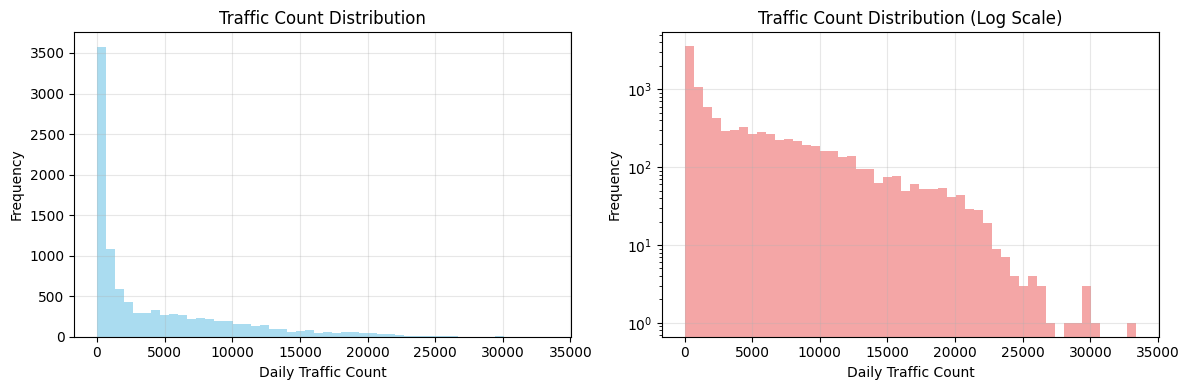

Traffic Count range: 0.0 to 33,399.0


In [25]:
key_numeric_fields = ["Traffic Count", "Lane Number"]
for col in key_numeric_fields:
    if col in df.columns:
        skew_val = df.select(skewness(F.col(col))).collect()[0][0]
        kurt_val = df.select(kurtosis(F.col(col))).collect()[0][0]
        print(f"{col} - Skewness: {skew_val:.3f}, Kurtosis: {kurt_val:.3f}")

print("Detailed Statistics Summary:")
if "Traffic Count" in df.columns:
    stats = df.select(
        F.min("Traffic Count").alias("min"),
        F.max("Traffic Count").alias("max"),
        F.mean("Traffic Count").alias("mean"),
        F.stddev("Traffic Count").alias("stddev"),
        skewness("Traffic Count").alias("skewness"),
        kurtosis("Traffic Count").alias("kurtosis")
    ).collect()[0]

    print(f"Traffic Count Statistics:")
    print(f"  Min: {stats['min']:,.0f}")
    print(f"  Max: {stats['max']:,.0f}")
    print(f"  Mean: {stats['mean']:,.0f}")
    print(f"  Std Dev: {stats['stddev']:,.0f}")
    print(f"  Skewness: {stats['skewness']:.3f}")
    print(f"  Kurtosis: {stats['kurtosis']:.3f}")

if "Traffic Count" in df.columns:
    sample_size = min(10000, df.count())
    traffic_sample = df.select("Traffic Count").sample(False, sample_size/df.count()).collect()
    traffic_values = [row[0] for row in traffic_sample if row[0] is not None]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(traffic_values, bins=50, alpha=0.7, color='skyblue')
    plt.title("Traffic Count Distribution")
    plt.xlabel("Daily Traffic Count")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(traffic_values, bins=50, alpha=0.7, color='lightcoral')
    plt.title("Traffic Count Distribution (Log Scale)")
    plt.xlabel("Daily Traffic Count")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Traffic Count range: {min(traffic_values):,} to {max(traffic_values):,}")

In [26]:
total_records = df.count()
print(f"Total records: {total_records:,}")
print("Field Completeness Summary:")

missing_stats = []
for col in df.columns:
    missing_count = df.filter(F.col(col).isNull()).count()
    missing_pct = (missing_count / total_records) * 100
    completeness_pct = 100 - missing_pct
    missing_stats.append((col, missing_count, missing_pct, completeness_pct))
    print(f"{col}: {missing_count:,} missing ({missing_pct:.1f}%), Completeness: {completeness_pct:.1f}%")

high_missing = [stat for stat in missing_stats if stat[2] > 10]
if high_missing:
    print("Fields with High Missing Rates (>10%):")
    for col, count, pct, completeness in high_missing:
        print(f"{col}: {pct:.1f}% missing - Consider exclusion or imputation")

Total records: 6,660,911
Field Completeness Summary:
OBJECTID: 0 missing (0.0%), Completeness: 100.0%
Start Date: 0 missing (0.0%), Completeness: 100.0%
Site Alias: 0 missing (0.0%), Completeness: 100.0%
Region Name: 0 missing (0.0%), Completeness: 100.0%
Site Reference: 0 missing (0.0%), Completeness: 100.0%
Class Weight: 0 missing (0.0%), Completeness: 100.0%
Site Description: 0 missing (0.0%), Completeness: 100.0%
Lane Number: 0 missing (0.0%), Completeness: 100.0%
Flow Direction: 0 missing (0.0%), Completeness: 100.0%
Traffic Count: 0 missing (0.0%), Completeness: 100.0%


Yearly Trends:
+----+------------------+------------+
|Year|       avg_traffic|record_count|
+----+------------------+------------+
|2017| 3533.981046931408|        1108|
|2018| 4449.199950847368|      777171|
|2019| 4504.342306663781|      785290|
|2020|4030.2855009768177|      814379|
|2021| 3983.123048006784|      871481|
|2022| 4234.794144184538|      903273|
|2023| 4129.629729069535|      945667|
|2024| 4203.356528468222|     1054474|
|2025|3756.3109406614863|      508068|
+----+------------------+------------+

Monthly Trends:
+-----+------------------+------------+
|Month|       avg_traffic|record_count|
+-----+------------------+------------+
|    1| 4156.165316858291|      596134|
|    2|4409.4979054523355|      552864|
|    3| 4318.819436576282|      596638|
|    4|3928.0481321278367|      550921|
|    5|  4084.66276322156|      603484|
|    6| 4006.069670384782|      570271|
|    7| 4132.554764869404|      552544|
|    8|3936.9725910348157|      543034|
|    9| 4084.82690459

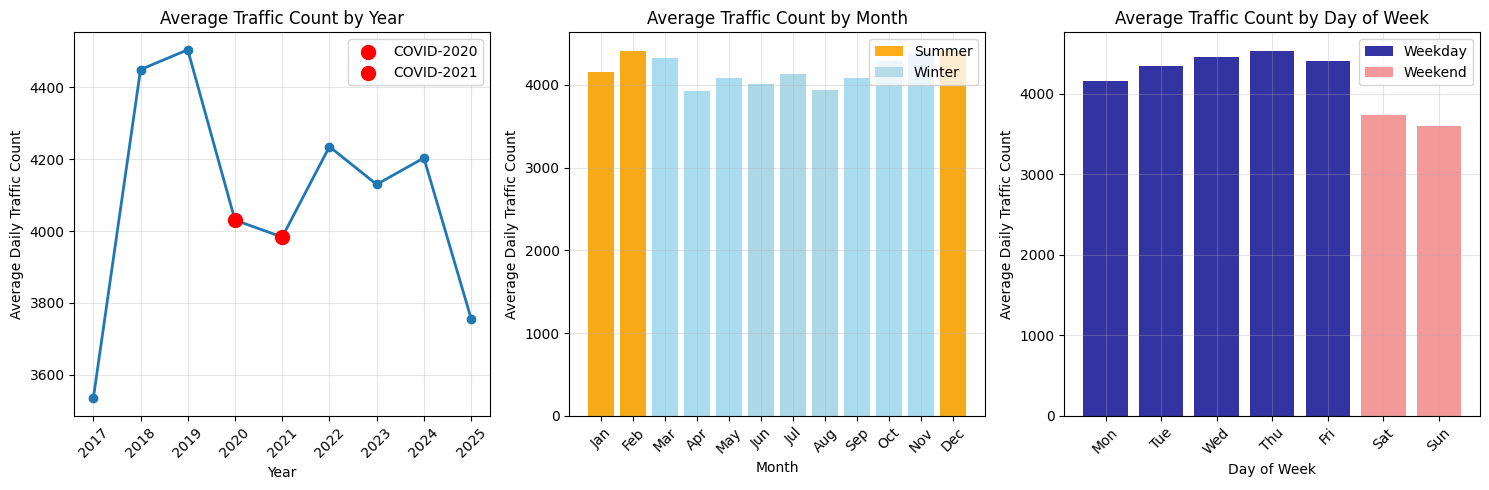

TEMPORAL PATTERN SUMMARY:
• Data spans 9 years (2017-2025)
• COVID-19 impact: -3.7% change in average traffic
• Seasonal variation: Summer +7.5% higher than winter
• Weekly pattern: Weekdays +19.4% higher than weekends


In [29]:
date_col = "Start Date"
if date_col in df.columns:
    df = df.withColumn("StartDate_parsed", F.to_timestamp(F.col(date_col), "M/d/yyyy h:mm:ss a")) \
           .withColumn("Year", F.year("StartDate_parsed")) \
           .withColumn("Month", F.month("StartDate_parsed")) \
           .withColumn("Weekday", F.date_format("StartDate_parsed", "E"))

# Yearly Trends Analysis and Visualization
if "Year" in df.columns and "Traffic Count" in df.columns:
    print("Yearly Trends:")
    yearly_trends = df.groupBy("Year").agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count")
    ).orderBy("Year")
    yearly_trends.show()

    # Create yearly trends visualization
    yearly_data = yearly_trends.toPandas()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(yearly_data['Year'], yearly_data['avg_traffic'], marker='o', linewidth=2, markersize=6)
    plt.title('Average Traffic Count by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Daily Traffic Count')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Highlight COVID years
    covid_years = [2020, 2021]
    for year in covid_years:
        if year in yearly_data['Year'].values:
            covid_traffic = yearly_data[yearly_data['Year'] == year]['avg_traffic'].iloc[0]
            plt.scatter(year, covid_traffic, color='red', s=100, zorder=5, label=f'COVID-{year}')
    plt.legend()

# Monthly Trends Analysis and Visualization
if "Month" in df.columns:
    print("Monthly Trends:")
    monthly_trends = df.groupBy("Month").agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count")
    ).orderBy("Month")
    monthly_trends.show()

    # Create monthly trends visualization
    monthly_data = monthly_trends.toPandas()

    plt.subplot(1, 3, 2)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.bar(range(1, 13), monthly_data['avg_traffic'], alpha=0.7, color='skyblue')
    plt.title('Average Traffic Count by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Daily Traffic Count')
    plt.xticks(range(1, 13), month_names, rotation=45)
    plt.grid(True, alpha=0.3)

    # Highlight seasonal patterns
    summer_months = [12, 1, 2]  # Dec, Jan, Feb
    winter_months = [6, 7, 8]   # Jun, Jul, Aug

    for month in summer_months:
        if month in monthly_data['Month'].values:
            plt.bar(month, monthly_data[monthly_data['Month'] == month]['avg_traffic'].iloc[0],
                   alpha=0.9, color='orange', label='Summer' if month == 12 else "")

    for month in winter_months:
        if month in monthly_data['Month'].values:
            plt.bar(month, monthly_data[monthly_data['Month'] == month]['avg_traffic'].iloc[0],
                   alpha=0.9, color='lightblue', label='Winter' if month == 6 else "")

    if len(summer_months) > 0 or len(winter_months) > 0:
        plt.legend()

# Weekly Trends Analysis and Visualization
if "Weekday" in df.columns:
    print("Weekly Trends:")
    weekly_trends = df.groupBy("Weekday").agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count")
    )
    weekly_trends.show()

    # Create weekly trends visualization
    weekly_data = weekly_trends.toPandas()

    # Sort weekdays properly
    weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weekly_data['weekday_num'] = weekly_data['Weekday'].map({day: i for i, day in enumerate(weekday_order)})
    weekly_data = weekly_data.sort_values('weekday_num')

    plt.subplot(1, 3, 3)
    colors = ['darkblue' if day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'] else 'lightcoral'
              for day in weekly_data['Weekday']]

    plt.bar(weekly_data['Weekday'], weekly_data['avg_traffic'], alpha=0.8, color=colors)
    plt.title('Average Traffic Count by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Daily Traffic Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add legend for weekday vs weekend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='darkblue', alpha=0.8, label='Weekday'),
                      Patch(facecolor='lightcoral', alpha=0.8, label='Weekend')]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

# Summary of temporal patterns
print("TEMPORAL PATTERN SUMMARY:")
if "Year" in df.columns:
    total_years = yearly_data['Year'].max() - yearly_data['Year'].min() + 1
    print(f"• Data spans {total_years} years ({yearly_data['Year'].min()}-{yearly_data['Year'].max()})")

    # Identify COVID impact
    pre_covid = yearly_data[yearly_data['Year'] < 2020]['avg_traffic'].mean() if len(yearly_data[yearly_data['Year'] < 2020]) > 0 else None
    covid_period = yearly_data[yearly_data['Year'].isin([2020, 2021])]['avg_traffic'].mean() if len(yearly_data[yearly_data['Year'].isin([2020, 2021])]) > 0 else None
    post_covid = yearly_data[yearly_data['Year'] > 2021]['avg_traffic'].mean() if len(yearly_data[yearly_data['Year'] > 2021]) > 0 else None

    if pre_covid and covid_period:
        covid_impact = ((covid_period - pre_covid) / pre_covid) * 100
        print(f"• COVID-19 impact: {covid_impact:+.1f}% change in average traffic")

if "Month" in df.columns:
    summer_avg = monthly_data[monthly_data['Month'].isin([12, 1, 2])]['avg_traffic'].mean()
    winter_avg = monthly_data[monthly_data['Month'].isin([6, 7, 8])]['avg_traffic'].mean()
    seasonal_diff = ((summer_avg - winter_avg) / winter_avg) * 100
    print(f"• Seasonal variation: Summer {seasonal_diff:+.1f}% higher than winter")

if "Weekday" in df.columns:
    weekday_avg = weekly_data[weekly_data['Weekday'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]['avg_traffic'].mean()
    weekend_avg = weekly_data[weekly_data['Weekday'].isin(['Sat', 'Sun'])]['avg_traffic'].mean()
    weekly_diff = ((weekday_avg - weekend_avg) / weekend_avg) * 100
    print(f"• Weekly pattern: Weekdays {weekly_diff:+.1f}% higher than weekends")

Regional Variation:
+--------------------+------------------+------------+-----------+
|         Region Name|       avg_traffic|record_count|max_traffic|
+--------------------+------------------+------------+-----------+
|       02 - Auckland|7320.2989363063225|     1922734|    33898.5|
|     09 - Wellington| 5302.600886483389|      795954|    64150.5|
|     11 - Canterbury|3127.0418054436996|     1172144|    30283.0|
|  04 - Bay of Plenty| 2954.219569709155|      215854|    33015.0|
|       07 - Taranaki|2704.5598258288533|      142848|    14242.5|
|     06 - Hawkes Bay|2674.2700324381094|      236142|    19859.0|
|        03 - Waikato| 2586.732368165976|      242445|    45112.0|
|10 - Nelson/Marlb...|2472.9051486671888|      282073|    16235.0|
|08 - Manawatu-Wan...| 2197.809905280425|      340162|    13286.0|
|          13 - Otago|2160.9641398650424|      570550|    16864.0|
|      01 - Northland|1676.4286457268338|      224962|    35328.0|
|      14 - Southland|1313.7928789683567| 

/tmp/ipython-input-1137502087.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(region_traffic_data, labels=region_labels)


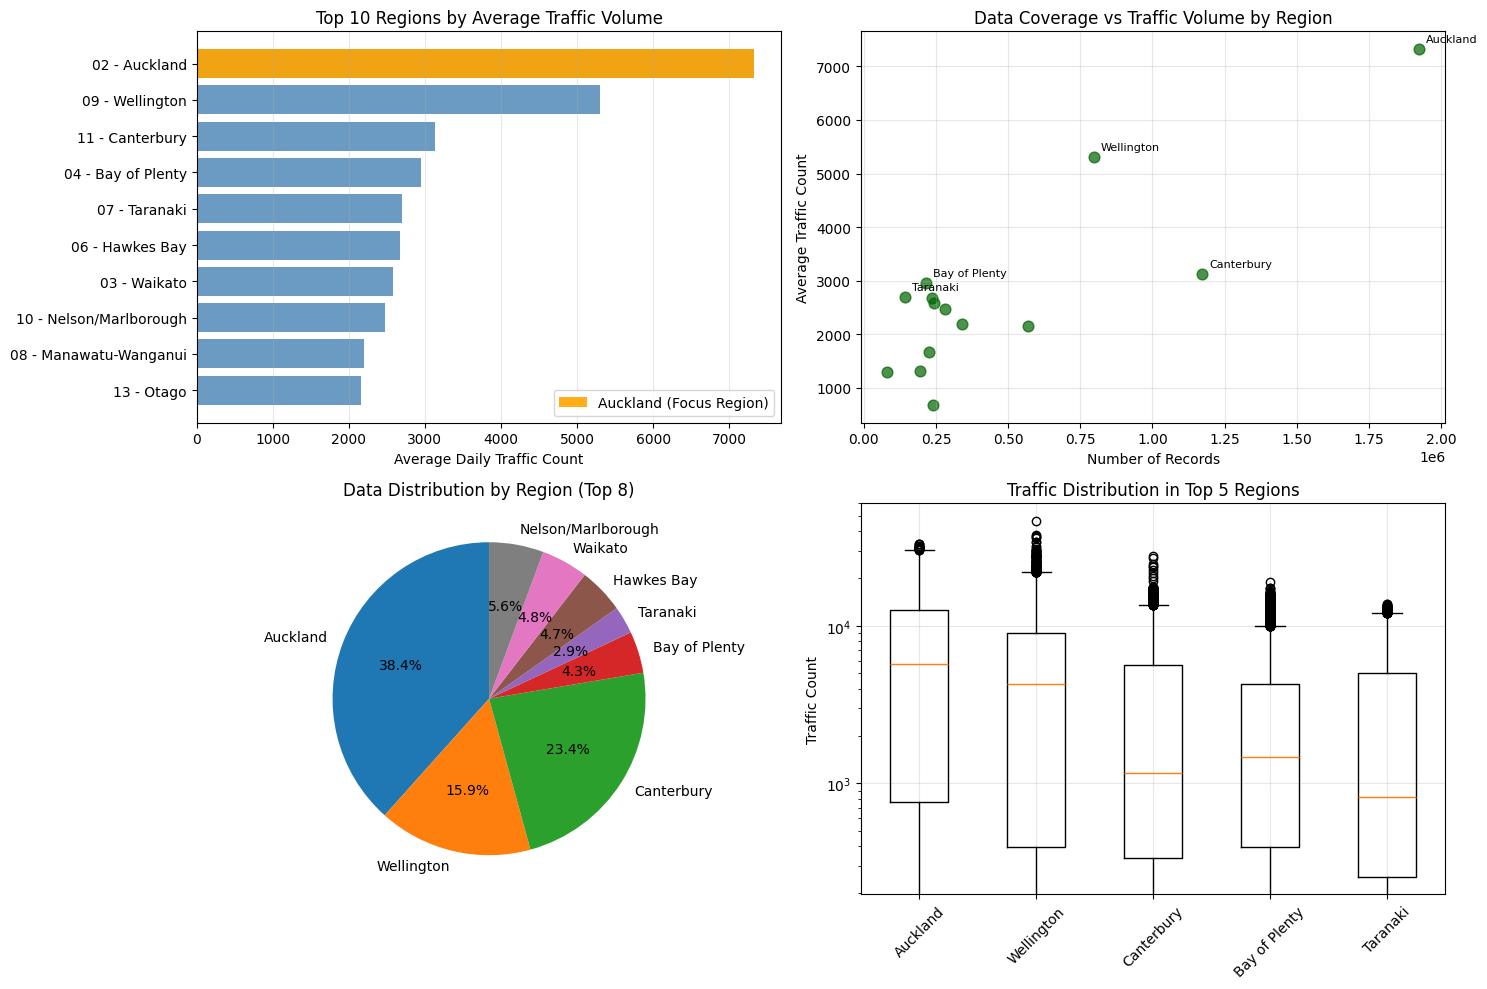

SPATIAL PATTERN SUMMARY:
• 14 regions covered in dataset
• Highest traffic region: 02 - Auckland (7320 avg daily)
• Lowest traffic region: 12 - West Coast (687 avg daily)
• Auckland ranks #1 in average traffic volume


In [32]:
region_col = "Region Name"
if region_col in df.columns:
    print("Regional Variation:")
    regional_stats = df.groupBy(region_col).agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count"),
        F.max("Traffic Count").alias("max_traffic")
    ).orderBy(F.desc("avg_traffic"))
    regional_stats.show(20)

    # Regional visualization
    regional_data = regional_stats.toPandas()

    plt.figure(figsize=(15, 10))

    # Top regions by average traffic
    plt.subplot(2, 2, 1)
    top_regions = regional_data.head(10)
    plt.barh(range(len(top_regions)), top_regions['avg_traffic'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_regions)), top_regions['Region Name'])
    plt.xlabel('Average Daily Traffic Count')
    plt.title('Top 10 Regions by Average Traffic Volume')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')

    # Highlight Auckland
    auckland_idx = top_regions[top_regions['Region Name'].str.contains('Auckland', na=False)].index
    if len(auckland_idx) > 0:
        auckland_pos = top_regions.index.get_loc(auckland_idx[0])
        plt.barh(auckland_pos, top_regions.loc[auckland_idx[0], 'avg_traffic'],
                color='orange', alpha=0.9, label='Auckland (Focus Region)')
        plt.legend()

    # Record count distribution
    plt.subplot(2, 2, 2)
    plt.scatter(regional_data['record_count'], regional_data['avg_traffic'],
               alpha=0.7, s=60, color='darkgreen')
    plt.xlabel('Number of Records')
    plt.ylabel('Average Traffic Count')
    plt.title('Data Coverage vs Traffic Volume by Region')
    plt.grid(True, alpha=0.3)

    # Annotate Auckland and other major regions
    for idx, row in regional_data.head(5).iterrows():
        plt.annotate(row['Region Name'].split(' - ')[1] if ' - ' in row['Region Name'] else row['Region Name'],
                    (row['record_count'], row['avg_traffic']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    # Regional traffic distribution
    plt.subplot(2, 2, 3)
    plt.pie(regional_data.head(8)['record_count'],
           labels=[name.split(' - ')[1] if ' - ' in name else name for name in regional_data.head(8)['Region Name']],
           autopct='%1.1f%%', startangle=90)
    plt.title('Data Distribution by Region (Top 8)')

    # Box plot comparison (top 5 regions)
    plt.subplot(2, 2, 4)
    top_5_regions = regional_data.head(5)['Region Name'].tolist()
    region_traffic_data = []
    region_labels = []

    for region in top_5_regions:
        traffic_data = df.filter(F.col(region_col) == region).select("Traffic Count").sample(False, 0.1).toPandas()
        if len(traffic_data) > 0:
            region_traffic_data.append(traffic_data['Traffic Count'].tolist())
            region_labels.append(region.split(' - ')[1] if ' - ' in region else region)

    if region_traffic_data:
        plt.boxplot(region_traffic_data, labels=region_labels)
        plt.ylabel('Traffic Count')
        plt.title('Traffic Distribution in Top 5 Regions')
        plt.xticks(rotation=45)
        plt.yscale('log')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("SPATIAL PATTERN SUMMARY:")
    print(f"• {len(regional_data)} regions covered in dataset")
    print(f"• Highest traffic region: {regional_data.iloc[0]['Region Name']} ({regional_data.iloc[0]['avg_traffic']:.0f} avg daily)")
    print(f"• Lowest traffic region: {regional_data.iloc[-1]['Region Name']} ({regional_data.iloc[-1]['avg_traffic']:.0f} avg daily)")

    auckland_data = regional_data[regional_data['Region Name'].str.contains('Auckland', na=False)]
    if len(auckland_data) > 0:
        auckland_rank = regional_data.index[regional_data['Region Name'].str.contains('Auckland', na=False)].tolist()[0] + 1
        print(f"• Auckland ranks #{auckland_rank} in average traffic volume")

Vehicle Class Distribution:
+------------+-----------------+------------+-----------------+
|Class Weight|      avg_traffic|record_count|   stddev_traffic|
+------------+-----------------+------------+-----------------+
|       Light|6706.751294282119|     3967064|5523.687561746452|
|       Heavy|451.9282050910835|     2693847|520.9039265195687|
+------------+-----------------+------------+-----------------+

Light vs Heavy Vehicle Detailed Analysis:
+------------+-----------+------+------+------+-----------+-----------------+------------+
|Class Weight|min_traffic|    q1|median|    q3|max_traffic|     mean_traffic|record_count|
+------------+-----------+------+------+------+-----------+-----------------+------------+
|       Light|        0.0|2152.0|5391.0|9839.5|    64150.5|6706.751294282119|     3967064|
|       Heavy|        0.0| 115.0| 265.5| 590.5|    19740.0|451.9282050910835|     2693847|
+------------+-----------+------+------+------+-----------+-----------------+------------+

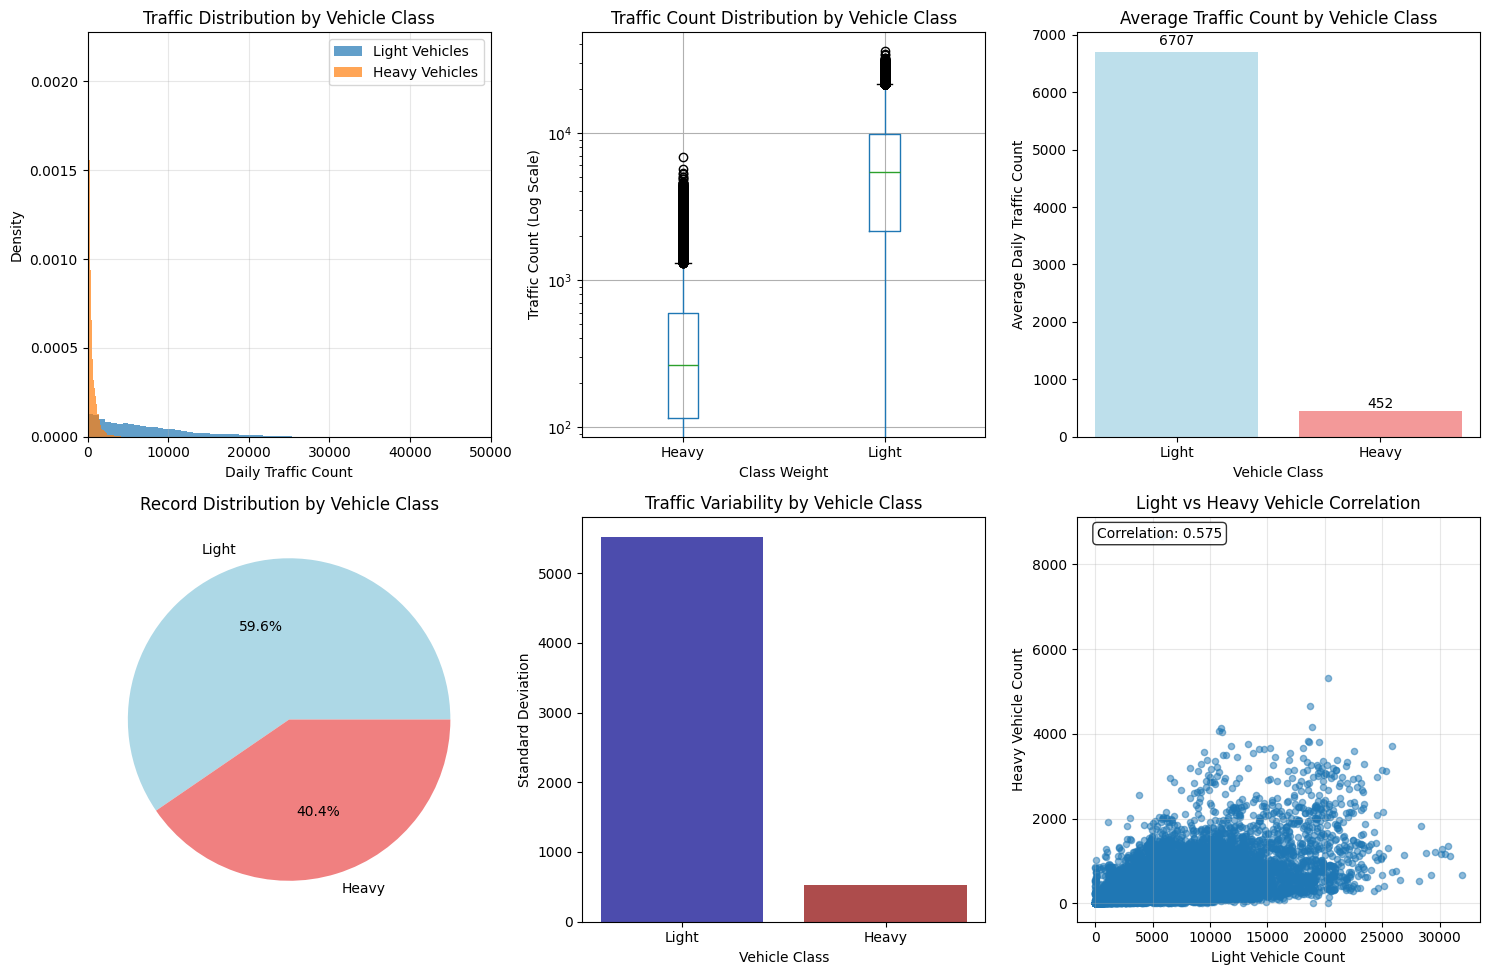

Flow Direction Frequencies:
+--------------+------------+------------------+
|Flow Direction|record_count|       avg_traffic|
+--------------+------------+------------------+
|             1|     2898156|4073.2784222105365|
|             2|     2887282| 4065.373233373117|
|             3|      237343| 4847.211575652115|
|             4|      202584| 5107.120295778541|
|             5|      221075| 4770.677236232048|
|             6|      214471| 4853.391516801806|
+--------------+------------+------------------+



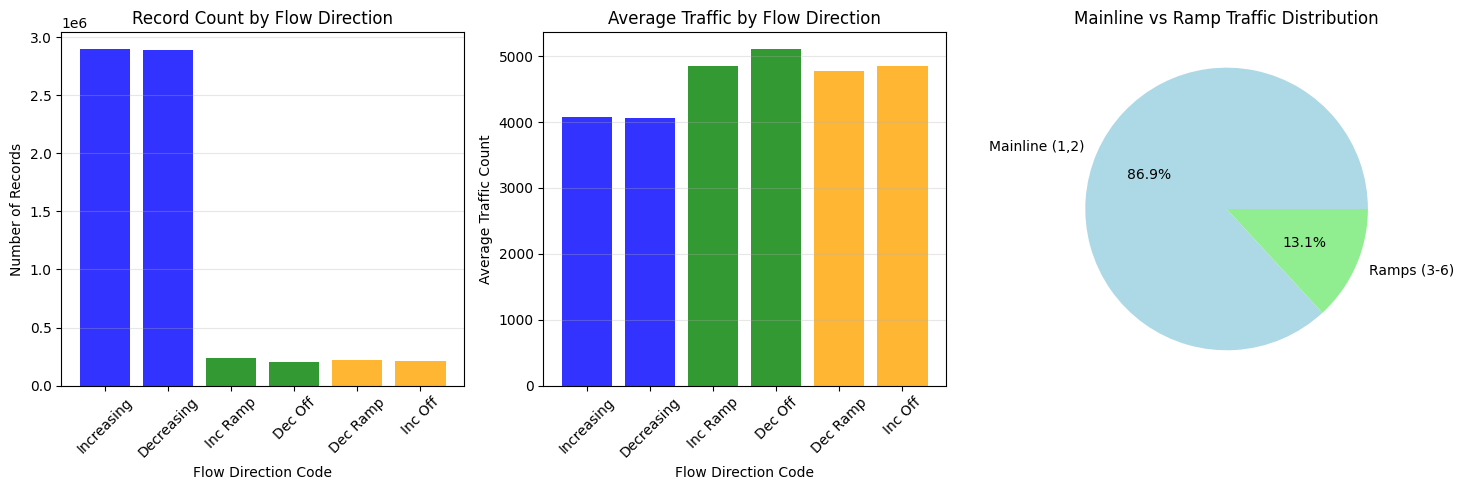

Flow Direction Code Interpretation:
0: Both directions, 1: Increasing, 2: Decreasing
3: Increasing on ramp, 4: Decreasing off ramp
5: Decreasing on ramp, 6: Increasing off ramp
FLOW DIRECTION SUMMARY:
• Mainline traffic: 86.9% of records
• Ramp traffic: 13.1% of records
• Most common direction: Code 1


In [33]:
class_col = "Class Weight"
if class_col in df.columns:
    print("Vehicle Class Distribution:")
    class_stats = df.groupBy(class_col).agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count"),
        F.stddev("Traffic Count").alias("stddev_traffic")
    )
    class_stats.show()

    print("Light vs Heavy Vehicle Detailed Analysis:")
    class_data = df.groupBy(class_col).agg(
        F.min("Traffic Count").alias("min_traffic"),
        F.expr("percentile_approx(`Traffic Count`, 0.25)").alias("q1"),
        F.expr("percentile_approx(`Traffic Count`, 0.5)").alias("median"),
        F.expr("percentile_approx(`Traffic Count`, 0.75)").alias("q3"),
        F.max("Traffic Count").alias("max_traffic"),
        F.mean("Traffic Count").alias("mean_traffic"),
        F.count("*").alias("record_count")
    )
    class_data.show()

    # Vehicle class visualization
    if len(df.select(class_col).distinct().collect()) == 2:
        sample_data = df.select(class_col, "Traffic Count").sample(False, 0.05).toPandas()
        class_summary = class_stats.toPandas()

        plt.figure(figsize=(15, 10))

        # Distribution comparison
        plt.subplot(2, 3, 1)
        for class_type in sample_data[class_col].unique():
            class_traffic = sample_data[sample_data[class_col] == class_type]["Traffic Count"]
            plt.hist(class_traffic, alpha=0.7, label=f'{class_type} Vehicles', bins=50, density=True)
        plt.xlabel('Daily Traffic Count')
        plt.ylabel('Density')
        plt.title('Traffic Distribution by Vehicle Class')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 50000)  # Focus on main distribution

        # Box plot comparison
        plt.subplot(2, 3, 2)
        sample_data.boxplot(column='Traffic Count', by=class_col, ax=plt.gca())
        plt.title('Traffic Count Distribution by Vehicle Class')
        plt.suptitle('')
        plt.yscale('log')
        plt.ylabel('Traffic Count (Log Scale)')

        # Average comparison
        plt.subplot(2, 3, 3)
        plt.bar(class_summary[class_col], class_summary['avg_traffic'],
               color=['lightblue', 'lightcoral'], alpha=0.8)
        plt.title('Average Traffic Count by Vehicle Class')
        plt.ylabel('Average Daily Traffic Count')
        plt.xlabel('Vehicle Class')

        # Add value labels on bars
        for i, v in enumerate(class_summary['avg_traffic']):
            plt.text(i, v + v*0.01, f'{v:.0f}', ha='center', va='bottom')

        # Record count comparison
        plt.subplot(2, 3, 4)
        plt.pie(class_summary['record_count'], labels=class_summary[class_col],
               autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
        plt.title('Record Distribution by Vehicle Class')

        # Standard deviation comparison
        plt.subplot(2, 3, 5)
        plt.bar(class_summary[class_col], class_summary['stddev_traffic'],
               color=['darkblue', 'darkred'], alpha=0.7)
        plt.title('Traffic Variability by Vehicle Class')
        plt.ylabel('Standard Deviation')
        plt.xlabel('Vehicle Class')

        # Scatter plot: Light vs Heavy correlation (sample data)
        plt.subplot(2, 3, 6)
        # Get paired data (same site, same date, different vehicle classes)
        light_heavy_comparison = df.select("Site Alias", "Start Date", class_col, "Traffic Count") \
                                  .groupBy("Site Alias", "Start Date") \
                                  .pivot(class_col) \
                                  .agg(F.first("Traffic Count")) \
                                  .sample(False, 0.01).toPandas()

        if 'Heavy' in light_heavy_comparison.columns and 'Light' in light_heavy_comparison.columns:
            valid_data = light_heavy_comparison.dropna()
            plt.scatter(valid_data['Light'], valid_data['Heavy'], alpha=0.5, s=20)
            plt.xlabel('Light Vehicle Count')
            plt.ylabel('Heavy Vehicle Count')
            plt.title('Light vs Heavy Vehicle Correlation')
            plt.grid(True, alpha=0.3)

            # Add correlation coefficient
            correlation = valid_data['Light'].corr(valid_data['Heavy'])
            plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Flow Direction Analysis
flow_col = "Flow Direction"
if flow_col in df.columns:
    print("Flow Direction Frequencies:")
    flow_stats = df.groupBy(flow_col).agg(
        F.count("*").alias("record_count"),
        F.avg("Traffic Count").alias("avg_traffic")
    ).orderBy(flow_col)
    flow_stats.show()

    # Flow direction visualization
    flow_data = flow_stats.toPandas()

    plt.figure(figsize=(15, 5))

    # Flow direction frequency
    plt.subplot(1, 3, 1)
    direction_labels = ['Both Dir', 'Increasing', 'Decreasing', 'Inc Ramp', 'Dec Off', 'Dec Ramp', 'Inc Off']
    colors = ['red', 'blue', 'blue', 'green', 'green', 'orange', 'orange']

    plt.bar(flow_data[flow_col], flow_data['record_count'],
           color=[colors[int(d)] if int(d) < len(colors) else 'gray' for d in flow_data[flow_col]], alpha=0.8)
    plt.xlabel('Flow Direction Code')
    plt.ylabel('Number of Records')
    plt.title('Record Count by Flow Direction')
    plt.xticks(flow_data[flow_col], [direction_labels[int(d)] if int(d) < len(direction_labels) else f'Code {int(d)}'
                                   for d in flow_data[flow_col]], rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Average traffic by direction
    plt.subplot(1, 3, 2)
    plt.bar(flow_data[flow_col], flow_data['avg_traffic'],
           color=[colors[int(d)] if int(d) < len(colors) else 'gray' for d in flow_data[flow_col]], alpha=0.8)
    plt.xlabel('Flow Direction Code')
    plt.ylabel('Average Traffic Count')
    plt.title('Average Traffic by Flow Direction')
    plt.xticks(flow_data[flow_col], [direction_labels[int(d)] if int(d) < len(direction_labels) else f'Code {int(d)}'
                                   for d in flow_data[flow_col]], rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Pie chart for mainline vs ramps
    plt.subplot(1, 3, 3)
    mainline_records = flow_data[flow_data[flow_col].isin([1, 2])]['record_count'].sum()
    ramp_records = flow_data[flow_data[flow_col].isin([3, 4, 5, 6])]['record_count'].sum()
    both_records = flow_data[flow_data[flow_col] == 0]['record_count'].sum() if 0 in flow_data[flow_col].values else 0

    sizes = [mainline_records, ramp_records, both_records] if both_records > 0 else [mainline_records, ramp_records]
    labels = ['Mainline (1,2)', 'Ramps (3-6)', 'Both Dir (0)'] if both_records > 0 else ['Mainline (1,2)', 'Ramps (3-6)']
    colors_pie = ['lightblue', 'lightgreen', 'lightyellow'] if both_records > 0 else ['lightblue', 'lightgreen']

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie)
    plt.title('Mainline vs Ramp Traffic Distribution')

    plt.tight_layout()
    plt.show()

    print("Flow Direction Code Interpretation:")
    print("0: Both directions, 1: Increasing, 2: Decreasing")
    print("3: Increasing on ramp, 4: Decreasing off ramp")
    print("5: Decreasing on ramp, 6: Increasing off ramp")

    print("FLOW DIRECTION SUMMARY:")
    mainline_pct = (mainline_records / flow_data['record_count'].sum()) * 100
    ramp_pct = (ramp_records / flow_data['record_count'].sum()) * 100
    print(f"• Mainline traffic: {mainline_pct:.1f}% of records")
    print(f"• Ramp traffic: {ramp_pct:.1f}% of records")
    print(f"• Most common direction: Code {flow_data.loc[flow_data['record_count'].idxmax(), flow_col]}")

Lane Number vs Traffic Count:
+-----------+------------------+------------+-----------+-----------+-----------------+
|Lane Number|       avg_traffic|record_count|min_traffic|max_traffic|   stddev_traffic|
+-----------+------------------+------------+-----------+-----------+-----------------+
|          1| 4001.430264703753|     3218277|        0.0|    64150.5|4891.519089651114|
|          2|3751.5227425461944|     2571304|        0.0|    36109.0|5172.169204660562|
|          3| 6656.864737158677|      518716|        0.0|    34808.0|6931.256647347619|
|          4| 5411.566631388012|      320307|        0.0|    26312.0|5305.926273822837|
|          5|3778.7414971424005|       25021|        0.0|    21224.5|4386.753477878559|
|          6|2551.1695031567388|        7286|        0.0|    15639.5|2960.454123239931|
+-----------+------------------+------------+-----------+-----------+-----------------+



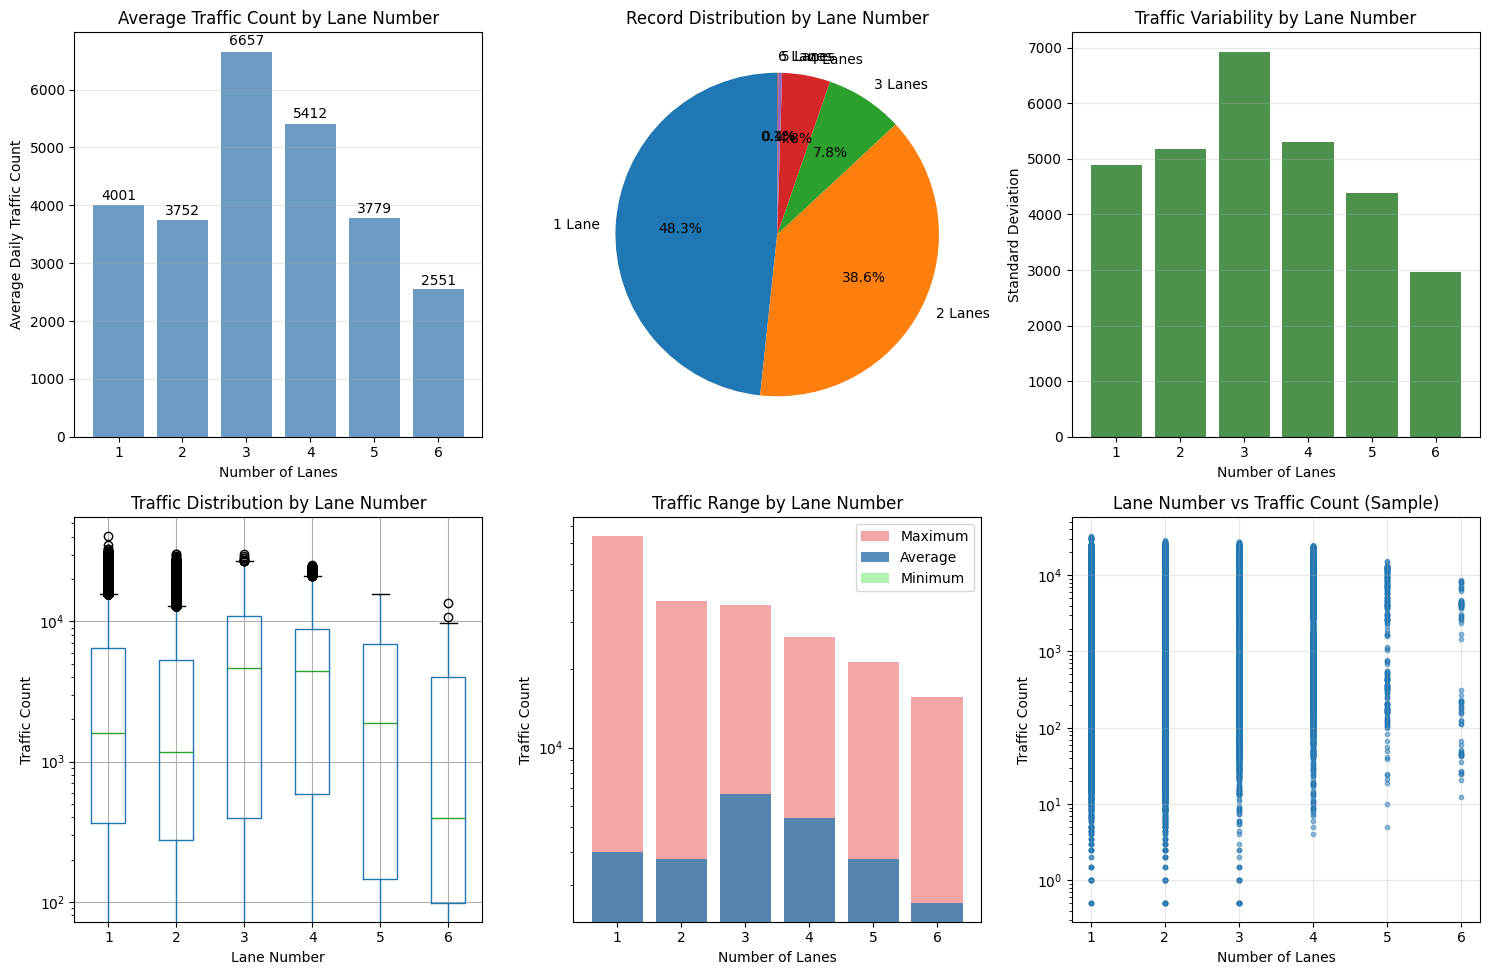

Updated numerical columns: ['OBJECTID', 'Site Alias', 'Lane Number', 'Flow Direction', 'Traffic Count', 'Year', 'Month']


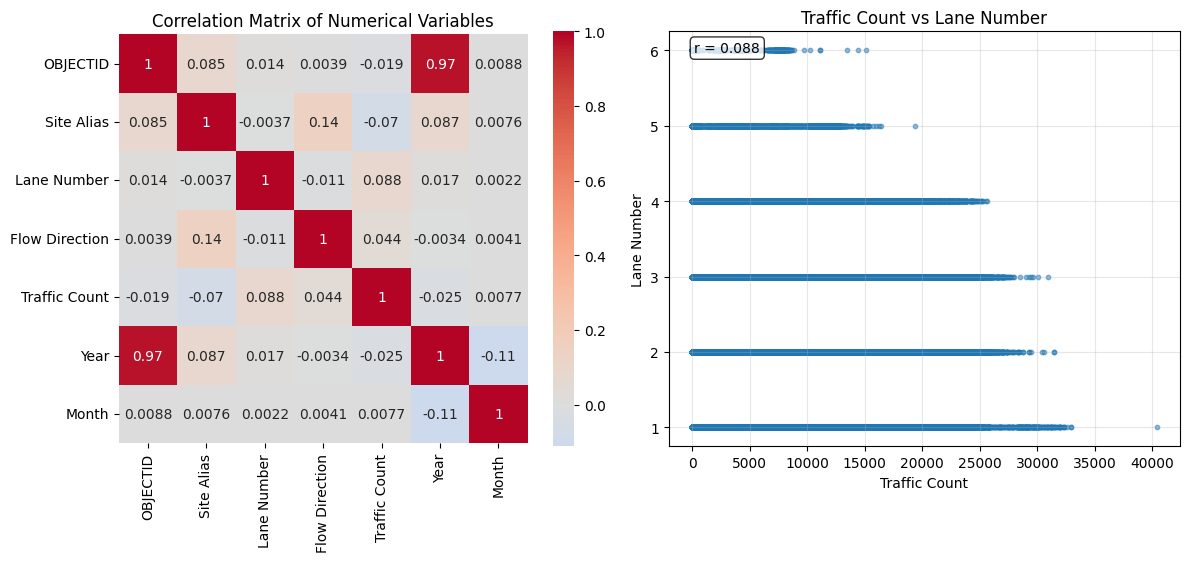

Correlation Matrix:
                OBJECTID  Site Alias  Lane Number  Flow Direction  \
OBJECTID           1.000       0.085        0.014           0.004   
Site Alias         0.085       1.000       -0.004           0.145   
Lane Number        0.014      -0.004        1.000          -0.011   
Flow Direction     0.004       0.145       -0.011           1.000   
Traffic Count     -0.019      -0.070        0.088           0.044   
Year               0.972       0.087        0.017          -0.003   
Month              0.009       0.008        0.002           0.004   

                Traffic Count   Year  Month  
OBJECTID               -0.019  0.972  0.009  
Site Alias             -0.070  0.087  0.008  
Lane Number             0.088  0.017  0.002  
Flow Direction          0.044 -0.003  0.004  
Traffic Count           1.000 -0.025  0.008  
Year                   -0.025  1.000 -0.112  
Month                   0.008 -0.112  1.000  
NUMERICAL FEATURES SUMMARY:
• Lane Number vs Traffic Count 

In [34]:
lane_col = "Lane Number"
if lane_col in df.columns:
    print("Lane Number vs Traffic Count:")
    lane_stats = df.groupBy(lane_col).agg(
        F.avg("Traffic Count").alias("avg_traffic"),
        F.count("*").alias("record_count"),
        F.min("Traffic Count").alias("min_traffic"),
        F.max("Traffic Count").alias("max_traffic"),
        F.stddev("Traffic Count").alias("stddev_traffic")
    ).orderBy(lane_col)
    lane_stats.show()

    # Lane analysis visualization
    lane_data = lane_stats.toPandas()

    plt.figure(figsize=(15, 10))

    # Average traffic by lane number
    plt.subplot(2, 3, 1)
    plt.bar(lane_data[lane_col], lane_data['avg_traffic'], color='steelblue', alpha=0.8)
    plt.xlabel('Number of Lanes')
    plt.ylabel('Average Daily Traffic Count')
    plt.title('Average Traffic Count by Lane Number')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, v in enumerate(lane_data['avg_traffic']):
        plt.text(lane_data[lane_col].iloc[i], v + v*0.01, f'{v:.0f}', ha='center', va='bottom')

    # Record distribution by lane number
    plt.subplot(2, 3, 2)
    plt.pie(lane_data['record_count'], labels=[f'{int(lanes)} Lane{"s" if lanes != 1 else ""}' for lanes in lane_data[lane_col]],
           autopct='%1.1f%%', startangle=90)
    plt.title('Record Distribution by Lane Number')

    # Traffic variability by lane number
    plt.subplot(2, 3, 3)
    plt.bar(lane_data[lane_col], lane_data['stddev_traffic'], color='darkgreen', alpha=0.7)
    plt.xlabel('Number of Lanes')
    plt.ylabel('Standard Deviation')
    plt.title('Traffic Variability by Lane Number')
    plt.grid(True, alpha=0.3, axis='y')

    # Box plot by lane number
    plt.subplot(2, 3, 4)
    lane_sample_data = df.select(lane_col, "Traffic Count").sample(False, 0.05).toPandas()
    lane_sample_data.boxplot(column='Traffic Count', by=lane_col, ax=plt.gca())
    plt.title('Traffic Distribution by Lane Number')
    plt.suptitle('')
    plt.ylabel('Traffic Count')
    plt.yscale('log')

    # Min-Max range by lane
    plt.subplot(2, 3, 5)
    x_pos = range(len(lane_data))
    plt.bar(x_pos, lane_data['max_traffic'], alpha=0.7, label='Maximum', color='lightcoral')
    plt.bar(x_pos, lane_data['avg_traffic'], alpha=0.9, label='Average', color='steelblue')
    plt.bar(x_pos, lane_data['min_traffic'], alpha=0.7, label='Minimum', color='lightgreen')
    plt.xlabel('Number of Lanes')
    plt.ylabel('Traffic Count')
    plt.title('Traffic Range by Lane Number')
    plt.xticks(x_pos, [f'{int(lanes)}' for lanes in lane_data[lane_col]])
    plt.legend()
    plt.yscale('log')

    # Scatter plot: Lane number vs traffic (sample)
    plt.subplot(2, 3, 6)
    sample_data = df.select(lane_col, "Traffic Count").sample(False, 0.01).toPandas()
    plt.scatter(sample_data[lane_col], sample_data['Traffic Count'], alpha=0.5, s=10)
    plt.xlabel('Number of Lanes')
    plt.ylabel('Traffic Count')
    plt.title('Lane Number vs Traffic Count (Sample)')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

# Updated correlation analysis
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (T.IntegerType, T.LongType, T.DoubleType, T.FloatType))]
print("Updated numerical columns:", numeric_cols)

if len(numeric_cols) > 1:
    sample_df = df.select(numeric_cols).sample(False, 0.1)
    pandas_df = sample_df.toPandas()

    plt.figure(figsize=(12, 10))

    # Correlation heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = pandas_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Matrix of Numerical Variables')

    # Pairwise scatter plots for key relationships
    key_pairs = [('Traffic Count', 'Lane Number')] if 'Traffic Count' in pandas_df.columns and 'Lane Number' in pandas_df.columns else []

    if key_pairs:
        for i, (col1, col2) in enumerate(key_pairs):
            plt.subplot(2, 2, i+2)
            plt.scatter(pandas_df[col1], pandas_df[col2], alpha=0.5, s=10)
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title(f'{col1} vs {col2}')
            plt.grid(True, alpha=0.3)

            # Add correlation coefficient
            corr = pandas_df[col1].corr(pandas_df[col2])
            plt.text(0.05, 0.95, f'r = {corr:.3f}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("Correlation Matrix:")
    print(correlation_matrix.round(3))

    print("NUMERICAL FEATURES SUMMARY:")
    if 'Lane Number' in pandas_df.columns and 'Traffic Count' in pandas_df.columns:
        lane_traffic_corr = pandas_df['Lane Number'].corr(pandas_df['Traffic Count'])
        print(f"• Lane Number vs Traffic Count correlation: {lane_traffic_corr:.3f}")

        peak_lane = lane_data.loc[lane_data['avg_traffic'].idxmax(), lane_col]
        print(f"• Peak traffic occurs at {int(peak_lane)} lanes")
        print(f"• Traffic relationship with infrastructure is non-linear")

In [37]:
def detailed_outlier_analysis(df, col_name):
    if col_name not in df.columns:
        print(f"Column {col_name} not found")
        return

    quantiles = df.approxQuantile(col_name, [0.25, 0.75, 0.99, 0.999], 0.001)
    if len(quantiles) == 4:
        Q1, Q3, P99, P999 = quantiles
        IQR = Q3 - Q1

        mild_outliers = df.filter(F.col(col_name) > (Q3 + 1.5 * IQR)).count()
        extreme_outliers = df.filter(F.col(col_name) > (Q3 + 3 * IQR)).count()
        statistical_outliers = df.filter(F.col(col_name) > P99).count()
        extreme_statistical = df.filter(F.col(col_name) > P999).count()

        print(f"{col_name} Detailed Outlier Analysis:")
        print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
        print(f"  P99: {P99}, P99.9: {P999}")
        print(f"  Mild outliers (>Q3+1.5*IQR): {mild_outliers:,}")
        print(f"  Extreme outliers (>Q3+3*IQR): {extreme_outliers:,}")
        print(f"  Above 99th percentile: {statistical_outliers:,}")
        print(f"  Above 99.9th percentile: {extreme_statistical:,}")

key_fields = ["Traffic Count", "Lane Number"]
for field in key_fields:
    detailed_outlier_analysis(df, field)

Traffic Count Detailed Outlier Analysis:
  Q1: 334.0, Q3: 6593.5, IQR: 6259.5
  P99: 21442.5, P99.9: 64150.5
  Mild outliers (>Q3+1.5*IQR): 318,230
  Extreme outliers (>Q3+3*IQR): 5,597
  Above 99th percentile: 63,872
  Above 99.9th percentile: 0
Lane Number Detailed Outlier Analysis:
  Q1: 1.0, Q3: 2.0, IQR: 1.0
  P99: 4.0, P99.9: 6.0
  Mild outliers (>Q3+1.5*IQR): 352,614
  Extreme outliers (>Q3+3*IQR): 7,286
  Above 99th percentile: 32,307
  Above 99.9th percentile: 0


In [38]:
if "Lane Number" in df.columns:
    lane_range = df.agg(F.min("Lane Number"), F.max("Lane Number")).collect()[0]
    print(f"Lane Number range: {lane_range[0]} to {lane_range[1]}")
    invalid_lanes = df.filter((F.col("Lane Number") < 1) | (F.col("Lane Number") > 6)).count()
    print(f"Invalid lane numbers (not 1-6): {invalid_lanes:,}")

if "Flow Direction" in df.columns:
    flow_range = df.agg(F.min("Flow Direction"), F.max("Flow Direction")).collect()[0]
    print(f"Flow Direction range: {flow_range[0]} to {flow_range[1]}")
    invalid_flows = df.filter((F.col("Flow Direction") < 0) | (F.col("Flow Direction") > 6)).count()
    print(f"Invalid flow directions (not 0-6): {invalid_flows:,}")

if "Traffic Count" in df.columns:
    negative_traffic = df.filter(F.col("Traffic Count") < 0).count()
    zero_traffic = df.filter(F.col("Traffic Count") == 0).count()
    print(f"Negative traffic counts: {negative_traffic:,}")
    print(f"Zero traffic counts: {zero_traffic:,}")

if "StartDate_parsed" in df.columns:
    date_range = df.agg(F.min("StartDate_parsed"), F.max("StartDate_parsed")).collect()[0]
    print(f"Date range: {date_range[0]} to {date_range[1]}")

if "Region Name" in df.columns:
    region_count = df.select("Region Name").distinct().count()
    print(f"Regions covered: {region_count}")

if "Year" in df.columns:
    print("Potential COVID Impact:")
    covid_years = df.filter(F.col("Year").isin([2020, 2021])) \
                    .groupBy("Year") \
                    .agg(F.avg("Traffic Count").alias("avg_traffic")) \
                    .orderBy("Year")
    covid_years.show()

categorical_fields = ["Region Name", "Class Weight", "Flow Direction"]
for field in categorical_fields:
    if field in df.columns:
        field_dist = df.groupBy(field).count().orderBy(F.desc("count"))
        print(f"{field} distribution (top 10):")
        field_dist.show(10)

Lane Number range: 1 to 6
Invalid lane numbers (not 1-6): 0
Flow Direction range: 1 to 6
Invalid flow directions (not 0-6): 0
Negative traffic counts: 0
Zero traffic counts: 23,481
Date range: 2017-12-31 12:00:00 to 2025-07-27 00:00:00
Regions covered: 14
Potential COVID Impact:
+----+------------------+
|Year|       avg_traffic|
+----+------------------+
|2020|4030.2855009768177|
|2021| 3983.123048006784|
+----+------------------+

Region Name distribution (top 10):
+--------------------+-------+
|         Region Name|  count|
+--------------------+-------+
|       02 - Auckland|1922734|
|     11 - Canterbury|1172144|
|     09 - Wellington| 795954|
|          13 - Otago| 570550|
|08 - Manawatu-Wan...| 340162|
|10 - Nelson/Marlb...| 282073|
|        03 - Waikato| 242445|
|     12 - West Coast| 240237|
|     06 - Hawkes Bay| 236142|
|      01 - Northland| 224962|
+--------------------+-------+
only showing top 10 rows

Class Weight distribution (top 10):
+------------+-------+
|Class We